<a href="https://colab.research.google.com/github/VYBH6/HOSS-PRM/blob/main/MSc_Dissertation_HOSS_PRM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
import numpy as np
import pymc as pm
import aesara as ar
from aesara.compile.ops import as_op
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The first section sets up the generative model of perception which produces awareness reports and carries out perceptual reality monitoring. This is an extension of the HOSS model in Fleming (2020).

The following is the copula model - a copula is a method for constructing multivariate distributions with arbitrary marginal distributions. In our case, the marginal distributions are beta distributions of A (awareness) and R (reality) states. These marginal distributions are sampled by drawing samples from a different distribution - a bivariate normal distribution, named *copula_samples* in the model. A and R samples are then calculated by transforming samples from each of the two dimensions of the bivariate normal. The addition of the copula allows us add correlations between samples of A and R, by setting the parameter *rho*. 

The generative model is set up using the PyMC package. Synthetic data is then used as an input to the model, and the posterior distribution is estimated using Markov Chain Monte Carlo (MCMC). Default priors for the alpha and beta parameters of the A, and R distributions are *alpha* = *beta* = 0.5 unless stated otherwise. 

In [ ]:
# function for calculating inverse beta CDF
@as_op(itypes=[ar.tensor.dvector], otypes=[ar.tensor.dscalar])
def InvBetaCDF(vals):
  x = vals[0]
  a = vals[1]
  b = vals[2]
  return np.array(st.beta.ppf(x, a, b))

# define function to call for inference - fun

def hoss_prm(X_samples, rho=0, A_alpha=0.5, A_beta=0.5, 
             R_alpha=0.5, R_beta=0.5, w12priors = [0.5, 0.5], ndraws=8000):

  with pm.Model() as copula_model:

      # define the copula distribution
      covmat = [[1, rho], [rho, 1]]
      copula_samples = pm.MvNormal('copula_dist', mu=[0,0], cov=covmat)

      # convert copula samples to uniform distribution
      U = pm.math.invprobit(copula_samples)

      # prior over R - reality state with R representing the probability of being real
      R_samples = U[0]
      R_vals = ar.tensor.as_tensor([R_samples, R_alpha, R_beta])
      R = pm.Deterministic('R', InvBetaCDF(R_vals))

      # precision prior calculated from R
      precision = pm.Gamma('precision', mu= 1+2*R, sigma=0.1, shape=2)
      
      # prior over A - awareness state representing the probability of awareness
      A_samples = U[1]
      A_vals = ar.tensor.as_tensor([A_samples, A_alpha, A_beta])
      A = pm.Deterministic('A', InvBetaCDF(A_vals))

      # W priors calculated from A - w12priors is [0.5, 0.5] by default meaning 
      # there is equal prior probability of stimulus identity
      w0prior = 50*(1-A)
      w1prior = 50*A*w12priors[0]
      w2prior = 50*A*w12priors[1]

      # inference on W-states
      weights = pm.Dirichlet('weights', a=[w0prior, w1prior, w2prior])
      
      # define W states by multivariate Gaussians with shared precision matrices
      W0 = pm.Normal.dist(mu=[0,0], tau=precision, shape=2)
      W1 = pm.Normal.dist(mu=[0,2], tau=precision, shape=2)
      W2 = pm.Normal.dist(mu=[2,0], tau=precision, shape=2)

      components = [W0, W1, W2]

      # W states are components in mixture distribution which generates X
      X = pm.Mixture('X', w=weights, comp_dists=components, observed=X_samples)

      trace = pm.sample(draws=ndraws, tune=2000, 
                          chains=4, cores=4, step=pm.Metropolis())
      return trace

**Figure 1.** A plot of the prior distributions of the generative model, and an example of drawing a sample from the prior. The next few sections together are used in the figure. Interpreting this as a cognitive process, this can be seen as running the model in a *top down* way, such as in cases of mental imagery where a visual representation is generated internally from the brain, independently of what input is being received via the senses in that moment. 

Copula prior sample = [ 0.0824943  -0.46441841]


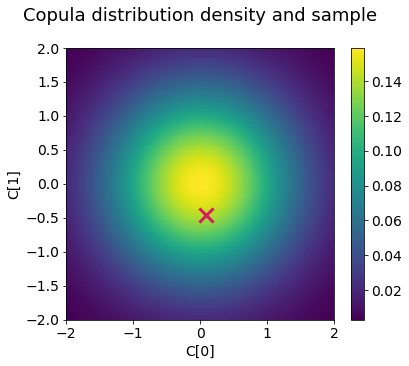

In [ ]:
# random seed for reproducibility
random_seed = 99
rng = np.random.default_rng(seed=random_seed)

# mean and covariance matrix of copula distribution
mean = np.array([0, 0])
cov_mat = np.array([[1,0],[0,1]])

# draw a sample from the copula distribution
draw_sample = st.multivariate_normal.rvs(mean, cov_mat, random_state = rng)
print(f'Copula prior sample = {draw_sample}')
x_val = draw_sample[0]
y_val = draw_sample[1]

# make a meshgrid to plot probability distribution heatmap
x = np.linspace(-2, 2, num=100)
y = np.linspace(-2, 2, num=100)
X, Y = np.meshgrid(x,y)

# calculate density function for each point in the meshgrid
distr = st.multivariate_normal(mean, cov_mat)
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    pdf[i,j] = distr.pdf([X[i,j], Y[i,j]])

# plot density and copula sample
fig, ax = plt.subplots(figsize=(6, 5))

plt.pcolormesh(X, Y, pdf, shading='auto', cmap='viridis')
ax.scatter(x_val, y_val, color='#D81B60', marker='x', s=200, linewidth=3)
plt.colorbar()

plt.xlabel('C[0]', fontsize=14)
plt.ylabel('C[1]', fontsize=14)
plt.title('Copula distribution density and sample\n', fontsize=18)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.show()

Samples of A and R calculated from the copula sample. A = 0.23364545830002195, R = 0.5515453239228033


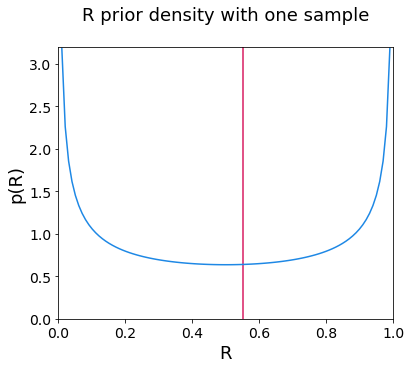

In [ ]:
# transform copula samples into samples from the uniform distribution
U_vals = st.norm.cdf(draw_sample, loc=0, scale=1)

# transform uniform distribution samples into A and R
R_sample = st.beta.ppf(U_vals[0], 0.5, 0.5)
A_sample = st.beta.ppf(U_vals[1], 0.5, 0.5)
print(f'Samples of A and R calculated from the copula sample. A = {A_sample}, R = {R_sample}')

# calculate probability density of R
x_R = np.linspace(0, 1, 100)
pdf_R = st.beta.pdf(x_R, 0.5, 0.5)

# plot density and sample
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(x_R, pdf_R, c='#1E88E5')
ax.vlines(R_sample, 0, 3.2, colors='#D81B60')

plt.xlim(0, 1)
plt.ylim(0, 3.2)

plt.xlabel('R', fontsize=18)
plt.ylabel('p(R)', fontsize=18)
plt.title('R prior density with one sample\n', fontsize=18)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.show()

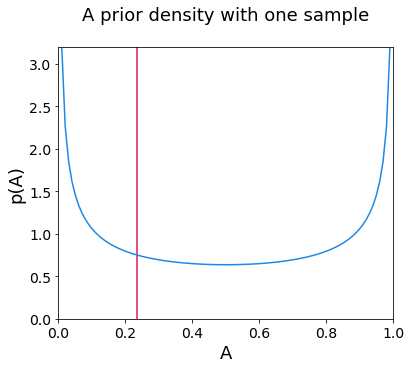

In [ ]:
# calculate probability density of A
x_A = np.linspace(0, 1, 100)
pdf_A = st.beta.pdf(x_A, 0.5, 0.5)

# plot density and sample
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(x_A, pdf_A, c='#1E88E5')
ax.vlines(A_sample, 0, 3.2, colors='#D81B60')

plt.xlim(0, 1)
plt.ylim(0, 3.2)

plt.xlabel('A', fontsize=18)
plt.ylabel('p(A)', fontsize=18)
plt.title('A prior density with one sample\n', fontsize=18)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.show()

W sample = [[0.73456121 0.15800391 0.10743488]]. These are the weights in the mixture model which defines the visual sample space X.


Text(0.5, 6.799999999999983, 'W')

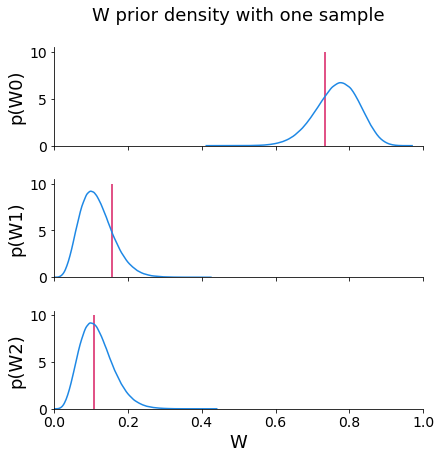

In [ ]:
# calculate parameters of dirichlet distribution from sample of A
dirch_parameters = np.array([50*(1-A_sample), 25*A_sample, 25*A_sample])

# draw samples from dirichlet distribution to plot density
dirch_samples = st.dirichlet.rvs(alpha=dirch_parameters, size=1000000, random_state = rng)
samples_dict = {'w0': dirch_samples[:,0], 'w1': dirch_samples[:,1], 'w2': dirch_samples[:,2]}
samples_df = pd.melt(pd.DataFrame(data=samples_dict))

# draw a sample of weights for mixture distribution
weights_sample = st.dirichlet.rvs(alpha=dirch_parameters, size=1, random_state = rng)
print(f'W sample = {weights_sample}. These are the weights in the mixture model which defines the visual sample space X.')

# plot grid of densities of weights
grid = sns.FacetGrid(samples_df, row="variable", height=2, aspect=3)
plt.xlim(0, 1)

grid.set_titles(None)
grid.map(sns.kdeplot, "value", color='#1E88E5')

axes = grid.axes.flatten()

for i in range(3):

  ax = axes[i]
  ax.vlines(weights_sample[0, i], 0, 10, colors='#D81B60')
  ax.set_title('')
  ax.set_ylabel(f'p(W{i})', fontsize=18)

axes[0].set_title('W prior density with one sample\n', fontsize=18)
axes[2].set_xlabel('W', fontsize=18)

Precision sample = [1.97628074]


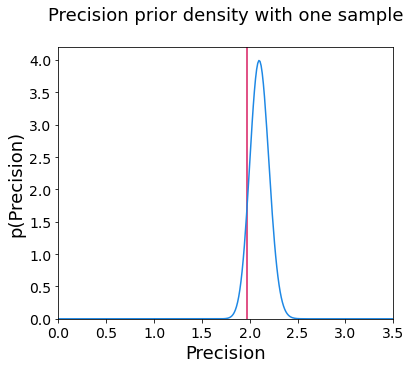

In [ ]:
# calculate probability density of precision and draw a sample
precision = np.linspace(0, 3.5, 300)
gamma_mean = 1 + 2*R_sample
gamma_sd = 0.1

gamma_alpha = gamma_mean ** 2 / gamma_sd ** 2
gamma_beta = gamma_mean / (gamma_sd ** 2)
scale = 1 / gamma_beta

pdf_precision = st.gamma.pdf(precision, gamma_alpha, scale=scale)
precision_sample = st.gamma.rvs(gamma_alpha, scale=scale, size=1, random_state = rng)
print(f'Precision sample = {precision_sample}')

# plot probability density of precision 
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(precision, pdf_precision, c='#1E88E5')
ax.vlines(precision_sample, 0, 4.2, colors='#D81B60')

plt.xlim(0, 3.5)
plt.ylim(0, 4.2)

plt.xlabel('Precision', fontsize=18)
plt.ylabel('p(Precision)', fontsize=18)
plt.title('Precision prior density with one sample\n', fontsize=18)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

plt.show()

In [ ]:
# calculate covariance matrix of mixture distribution
X_covmat = [[1/precision_sample,0], [0, 1/precision_sample]]

# function for calculating pdf of mixture distribution
def X_pdf(val, weights_sample):

  distr_w0 = st.multivariate_normal([0,0], X_covmat)
  distr_w1 = st.multivariate_normal([0,2], X_covmat)
  distr_w2 = st.multivariate_normal([2,0], X_covmat)

  pdf = (weights_sample[0,0]*distr_w0.pdf(val) 
        + weights_sample[0,1]*distr_w1.pdf(val) 
        + weights_sample[0,2]*distr_w2.pdf(val))

  return pdf

# define meshgrid for calculating density of mixture distribution
x = np.linspace(-2.2, 3.5, num=200)
y = np.linspace(-2.5, 4, num=200)
X, Y = np.meshgrid(x,y)

# sample from prior - first pick which distribution sample is drawn from
which_dist = rng.choice(3, size=500, p=weights_sample[0,:])

X_samples = {}

for i in range(3):
  means_list = [[0,0], [0,2], [2,0]]

  # find how many samples were drawn from each distribution in our mixture
  samples_count = (which_dist == i).sum()

  # draw random samples from each component in mixture
  X_samples[i] = st.multivariate_normal.rvs(means_list[i], X_covmat, size = samples_count, random_state = rng)

# calculate density function for each point in the meshgrid
pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
  for j in range(X.shape[1]):
    pdf[i,j] = X_pdf([X[i,j], Y[i,j]], weights_sample)

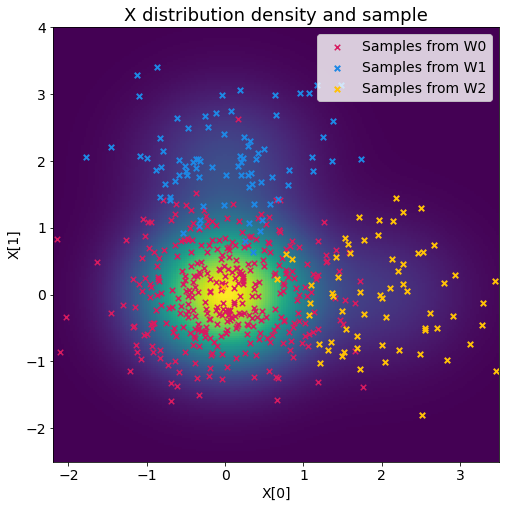

In [ ]:
# plot samples from mixture distribution

fig, ax = plt.subplots(figsize=(8, 8))

plt.pcolormesh(X, Y, pdf, shading='auto', cmap='viridis')

plt.scatter(X_samples[0][:,0], X_samples[0][:,1], color='#D81B60', marker='x', s=30, linewidth=1.5)
plt.scatter(X_samples[1][:,0], X_samples[1][:,1], color='#1E88E5', marker='x', s=30, linewidth=2)
plt.scatter(X_samples[2][:,0], X_samples[2][:,1], color='#FFC107', marker='x', s=30, linewidth=2)

plt.title('X distribution density and sample', fontsize=18)
plt.ylim(-2.5, 4)
plt.xlim(-2.2, 3.5)

plt.xlabel('X[0]', fontsize=14)
plt.ylabel('X[1]', fontsize=14)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

plt.legend(['Samples from W0', 'Samples from W1', 'Samples from W2'], fontsize=14)

plt.show()

Synthetic data of samples from the input perceptual space X are used as an input to the model and the posterior distribution is estimated using MCMC. Results are plotted for samples generated from different points X. 

In [ ]:
# function for generating samples of X
def gen_X_samples(X_mean, precision, nsamples):
  
  var = 1/precision
  X_covmat = np.array([[var, 0],
                      [0, var]])
  X_samples = rng.multivariate_normal(X_mean, X_covmat, size=nsamples)

  return X_samples

In [ ]:
# generate samples of X
X_samples = gen_X_samples([0, 1.8], 3, 500)

# attempt inference
mcmc_data = hoss_prm(X_samples=X_samples)

Checking convergence statistics for data generated with a mean at X = [0, 2] with a high precision of 3, which corresponds to perceiving a right-tilted grating. 

In [ ]:
# summary statistics of MCMC inference
az.summary(mcmc_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
copula_dist[0],1.547,0.512,0.742,2.525,0.009,0.006,3166.0,3116.0,1.00
copula_dist[1],1.486,0.306,0.919,2.052,0.031,0.022,96.0,1127.0,1.04
precision[0],2.965,0.102,2.767,3.153,0.002,0.001,2992.0,3073.0,1.00
precision[1],3.012,0.102,2.820,3.204,0.002,0.001,3298.0,3496.0,1.00
weights[0],0.003,0.004,0.000,0.011,0.001,0.000,41.0,145.0,1.09
weights[1],0.962,0.008,0.948,0.976,0.000,0.000,398.0,2050.0,1.02
weights[2],0.034,0.007,0.022,0.047,0.000,0.000,9762.0,10318.0,1.00
R,0.975,0.030,0.916,1.000,0.001,0.000,3166.0,3116.0,1.00
A,0.981,0.020,0.944,1.000,0.002,0.001,96.0,1127.0,1.04


**Figure 2.** Posterior trace and sample plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f154ad92a00>,
      dtype=object)

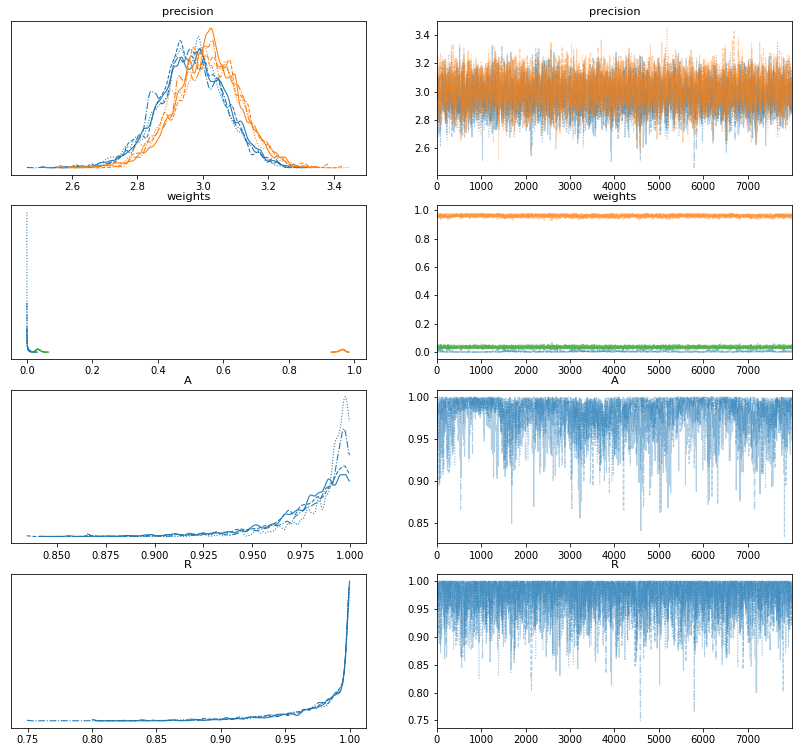

In [ ]:
# posterior trace plot
az.plot_trace(mcmc_data, var_names=['precision', 'weights', 'A', 'R'],
              figsize=(14, 13))

This section tests the model using parameter recovery. Data is generated from the prior (similar to what's described and shown in Figure 1), then that data is used as an input to the model. This generates data for which the true value of the parameter is known - the goal for the model now is to see whether the estimated value of the parameter is close to the ground truth. A failure to recover parameters could indicate priors that too restrictive.

First, define functions for parameter recovery and plotting.

In [ ]:
def generate_prior_samples(param, set_value):

  with pm.Model() as copula_model:

      # set value of chosen parameter and define prior for other parameter
      if param == 'R':
        R = set_value
        A = pm.Beta('A', alpha=0.5, beta=0.5)
      
      elif param == 'A':
        R = pm.Beta('R', alpha=0.5, beta=0.5)
        A = set_value

      # precision prior calculated from R
      precision = pm.Gamma('precision', mu=1+2*R, sigma=0.1, shape=2)
      
      # W priors calculated from A
      w12priors = [0.5, 0.5]

      w0prior = 50*(1-A)
      w1prior = 50*A*w12priors[0]
      w2prior = 50*A*w12priors[1]

      # inference on W-states
      weights = pm.Dirichlet('weights', a=[w0prior, w1prior, w2prior])
      
      # define W states by multivariate Gaussians with means and shared precision matrices
      W0 = pm.Normal.dist(mu=[0,0], tau=precision, shape=2)
      W1 = pm.Normal.dist(mu=[0,2], tau=precision, shape=2)
      W2 = pm.Normal.dist(mu=[2,0], tau=precision, shape=2)

      components = [W0, W1, W2]

      # W states are components in mixture distribution which generates X
      X = pm.Mixture('X', w=weights, comp_dists=components, observed=X_samples)

      #sample from prior distribution
      prior_samples = pm.sample_prior_predictive(samples=100, random_seed=random_seed)

      return prior_samples

# function for parameter recovery over range of values from 0 to 1
def mcmc_parameter_recovery(param):

  # list of parameter values to sample from prior
  # replace 0 and 1 with nearby values to prevent error for generating A
  param_values = np.concatenate(([0.0001], np.linspace(0.1, 0.9, 9), [0.9999]))

  # initialise dict of inferred values
  data_dict = {'means': [], 'CI_upper': [], 'CI_lower':[], 'Rhat':[]}

  for val in param_values:

    # generate samples from prior distribution
    prior_samples = generate_prior_samples(param=param, set_value=val)

    # sampler generated 100 sets of prior samples - select one at random
    X_array = prior_samples.prior_predictive['X']
    X_numpy = X_array.to_numpy()
    choose_samples = rng.integers(0, 100)
    selected_samples = X_numpy[0, choose_samples, :, :]

    # now try inference with selected samples from prior 
    recovery_data = hoss_prm(X_samples=selected_samples)

    # calculate summary statistics for inference
    summary_table = az.summary(recovery_data, hdi_prob=0.95)

    # append summary statistics to table
    for key, output in zip(data_dict.keys(), 
                           ['mean', 'hdi_97.5%', 'hdi_2.5%', 'r_hat']):
      data_dict[key].append(summary_table[output][param])

  # print maximum Rhat value to check convergence
  max_rhat = max(data_dict['Rhat'])
  max_rhat_index = data_dict['Rhat'].index(max_rhat)
  print(f'Maximum Rhat = {max_rhat} at {param} = {param_values[max_rhat_index]}')

  return data_dict

# function for plotting recovered parameters with confidence range
def param_recovery_plot(data, param):

  # extract data from dictionary
  upper_range = data['CI_upper']
  lower_range = data['CI_lower']
  post_means = data['means']
  
  # calculate CI bar heights and set parameter values for plotting
  bar_heights = np.array(upper_range) - np.array(lower_range)
  x_bar_coords = np.linspace(0.05, 1.05, 11)
  param_values = np.linspace(0, 1, 11)

  # plot and display figure
  fig, ax = plt.subplots(figsize=(10, 10))

  plt.bar(x=x_bar_coords, height=bar_heights, bottom=lower_range, width = 0.05, alpha=0.4, color='#1E88E5', label='95% confidence range')
  plt.hlines(param_values, param_values, param_values+0.1, color = '#FFC107', linestyle='--', linewidth=4, label=f'Value of {param} in generative model')
  plt.hlines(post_means, param_values, param_values+0.1, linewidth=4, color='#1E88E5', label=f'Posterior mean of {param}')

  ax.legend(loc=(1.05, 0.5), fontsize=15)
  ax.set_title(f'Parameter recovery of {param} values', size=20)

  plt.xlim(0, 1.1)
  plt.ylim(0, 1)

  plt.ylabel(f'Value of {param}', fontsize=20)

  plt.show()

In [ ]:
R_data = mcmc_parameter_recovery(param='R')

Maximum Rhat = 1.01 at R = 0.2


**Figure 3.** Parameter recovery for values of R and A.

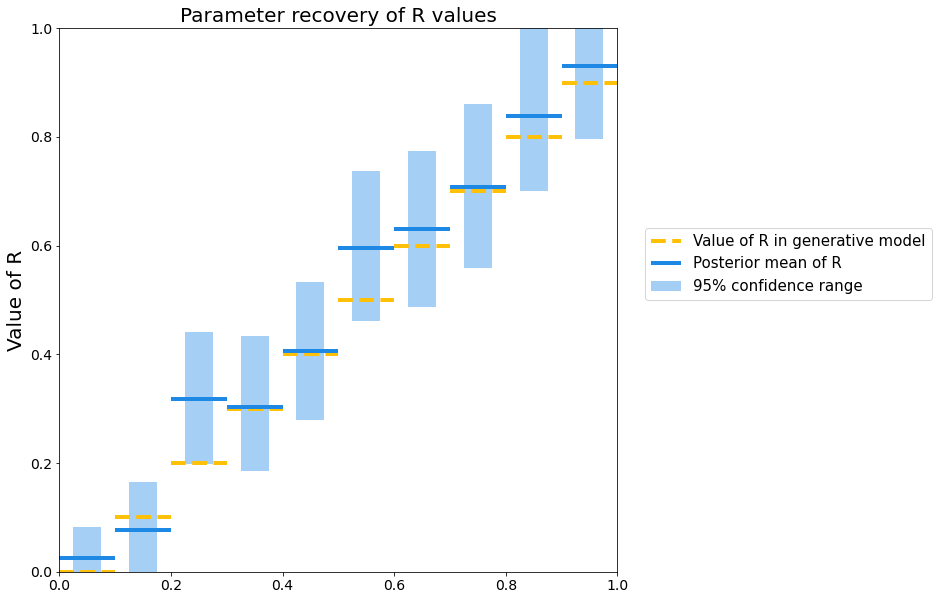

In [ ]:
param_recovery_plot(data=R_data, param='R')

In [ ]:
A_data = mcmc_parameter_recovery(param='A')

Maximum Rhat = 1.04 at A = 0.0001


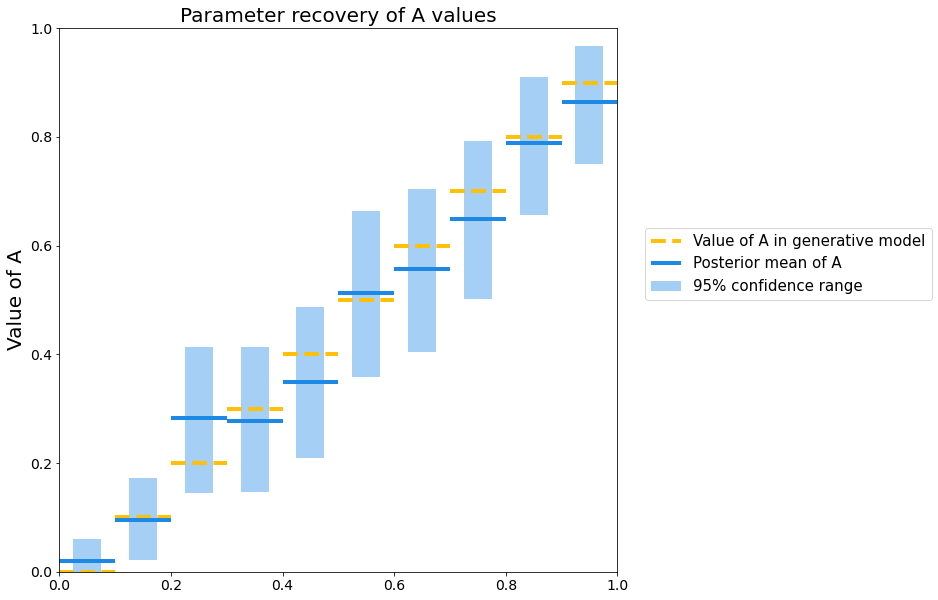

In [ ]:
param_recovery_plot(data=A_data, param='A')

Parameter recovery plots show that the model is able to successfully recover parameters when sampling from the prior. 

Next, we attempt to see how the model responds to a range of synthetic data. 500 samples of X are generated with a high precision of 3 for a grid of X values in a square grid. This effectively simulates how the model responds to intermediate and threshold inputs - recall that distance from the origin is taken to simulate input strength, thus an input at [0, 1] (between W0 at [0, 0] and W1 at [0, 2]) corresponds to a dim, briefly flashed and/or masked tilted grating which would elicit a mix of "presence" and "absence" responses from subjects in a detection task. 

The synthetic data is used as an input to the model, and the mean parameter values from the posterior distributions are plotted. 

In [ ]:
# NOTE: takes a while to run, 121 data points
# create grid of means in X space to generate samples and plot posterior
x = np.linspace(0, 2, num=11)
y = np.linspace(0, 2, num=11)
X, Y = np.meshgrid(x,y)
XYpairs = np.dstack([X, Y]).reshape(-1, 2)

data_list = []

# generate samples for each mean and sample posterior
for mean in XYpairs:

  X_samples = gen_X_samples(X_mean=mean, precision=3, nsamples=500)
  data_list.append(hoss_prm(X_samples=X_samples))

In [ ]:
params = ['A', 'R', 'weights[0]', 'weights[1]', 'weights[2]']
means_dict = {}
Rhat_dict = {}

# loop over parameter then get mean and Rhat for each data point
for param in params:
  means_dict[param] = []
  Rhat_dict[param] = []

for i in range(np.shape(XYpairs)[0]):
    data_summary = az.summary(data_list[i])
    for param in params:
      means_dict[param].append(data_summary['mean'][param])
      Rhat_dict[param].append(data_summary['r_hat'][param])

Print maximum R hat values to check for potential convergence issues. 

In [ ]:
for key in Rhat_dict.keys():
  max_Rhat = max(Rhat_dict[key])
  max_coord_index = Rhat_dict[key].index(max_Rhat)
  print(f'Maximum Rhat for {key} = {max_Rhat} at coordinate {XYpairs[max_coord_index, :]}')

Maximum Rhat for A = 1.29 at coordinate [1.8 0. ]
Maximum Rhat for R = 1.02 at coordinate [0.4 0. ]
Maximum Rhat for weights[0] = 1.9 at coordinate [1.6 1.4]
Maximum Rhat for weights[1] = 1.15 at coordinate [0.6 0. ]
Maximum Rhat for weights[2] = 1.1 at coordinate [0.  0.2]


Some of these Rhat values are higher than desired, however they're at coordinates where the magnitude of the parameter is low. Since Rhat depends on variance, in these cases a larger variance relative to the value of the parameter still leads to a small absolute estimated range of values. For an example, consider earlier table of values with Rhat = 1.09 for W0, which was estimated with mean 0.003 and a standard deviation of 0.004. In these cases higher values of Rhat are not problematic since running the chains with a much larger number of samples would lead to a more stable and precise numerical estimate of the posterior mean, however it would not lead to more insight from the model. The main points of interest are the clear trends seen in the plots below, for which the current posterior estimates are sufficient. 

**Figure 4.** Grid of A, R, and W posterior means. 

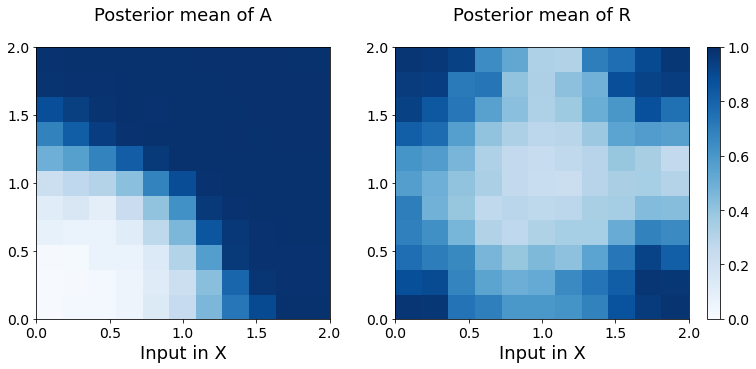

In [ ]:
# get grid of A and R values
A_grid = np.array(means_dict['A']).reshape([11, 11])
R_grid = np.array(means_dict['R']).reshape([11, 11])

# plot grid of posterior A and R values
fig, axs = plt.subplots(ncols=2, figsize=(13, 5), 
                        gridspec_kw={'width_ratios': [1, 1.25]})

labels = ['0.0', '0.5', '1.0', '1.5', '2.0']

c_A = axs[0].pcolor(A_grid, cmap='Blues', vmin=0, vmax=1)
plt.colorbar(c_A)
axs[0].set_title('Posterior mean of A\n', fontsize=18)
axs[0].set_xlabel('Input in X', fontsize=18)

axs[1].pcolor(R_grid, cmap='Blues', vmin=0, vmax=1)
axs[1].set_title('Posterior mean of R\n', fontsize=18)
axs[1].set_xlabel('Input in X', fontsize=18)

for i in [0, 1]:
  axs[i].set_xticks(np.linspace(0, 11, 5))
  axs[i].set_xticklabels(labels)
  axs[i].set_yticks(np.linspace(0, 11, 5))
  axs[i].set_yticklabels(labels)

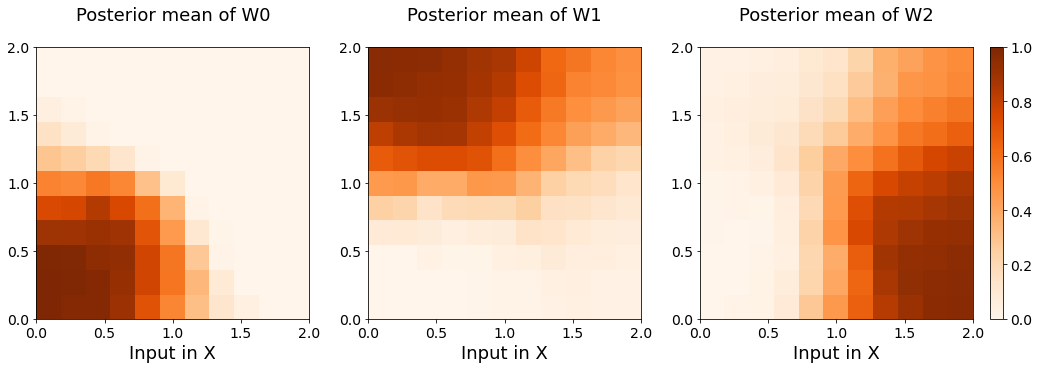

In [ ]:
# get grids of W0, W1 and W2 posterior means
W0_grid = np.array(means_dict['weights[0]']).reshape([11, 11])
W1_grid = np.array(means_dict['weights[1]']).reshape([11, 11])
W2_grid = np.array(means_dict['weights[2]']).reshape([11, 11])

# plot W0, W1, and W2 values
fig, axs = plt.subplots(ncols=3, figsize=(18, 5), 
                       gridspec_kw={'width_ratios': [1, 1, 1.25]})

c_W0 = axs[0].pcolor(W0_grid, cmap='Oranges', vmin=0, vmax=1)
plt.colorbar(c_W0)
axs[0].set_title('Posterior mean of W0\n', fontsize=18)
axs[0].set_xlabel('Input in X', fontsize=18)

axs[1].pcolor(W1_grid, cmap='Oranges', vmin=0, vmax=1)
axs[1].set_title('Posterior mean of W1\n', fontsize=18)
axs[1].set_xlabel('Input in X', fontsize=18)

axs[2].pcolor(W2_grid, cmap='Oranges', vmin=0, vmax=1)
axs[2].set_title('Posterior mean of W2\n', fontsize=18)
axs[2].set_xlabel('Input in X', fontsize=18)

for i in [0, 1, 2]:
  axs[i].set_xticks(np.linspace(0, 11, 5))
  axs[i].set_xticklabels(labels)
  axs[i].set_yticks(np.linspace(0, 11, 5))
  axs[i].set_yticklabels(labels)

The model is consistent with the idea that reality monitoring failures for perceived stimuli (i.e. mistaking perceived stimuli for imagined ones) is more likely to happen at stimuli with a weak input strength, since the reality monitoring process uses input strength to infer the source of a percept. Vivid mental imagery is similar to low visibility perceived stimuli - so source confusions are more likely to happen here. Even highly vivid mental imagery is still much weaker than clearly perceived stimuli - so in cases where the input is strong, there is no confusion about the source since it's known that only external perception could generate such a clearly visible stimulus. 

The next section investigates this further by restricting the inputs to only varying along one axis, plotting confidence ranges, and comparing perception with mental imagery. 

First, define the functions for MCMC and plotting. 

In [ ]:
# function for inference on data ranging from origin to [0, 2]
def inference_range(gen_precision):

  # range of coordinates and initialise dictionary for storing data
  coords_range = np.linspace(0, 2, 11)
  data_dict = {'precision': gen_precision}
  data_dict['coords'] = []

  data_names = ['A', 'weights[0]', 'weights[1]', 'weights[2]', 
                'R', 'precision[0]', 'precision[1]']
  data_params = ['mean', 'sd', 'hdi_2.5%', 'hdi_97.5%', 'r_hat']

  for name in data_names: 
      data_dict[name] = {}
      for param in data_params:
        data_dict[name][param] = []

  for coord in coords_range:

    data_dict['coords'].append(coord)

    # generate X samples and sample posterior distribution
    X_samples = gen_X_samples([0, coord], gen_precision, 500)
    data = hoss_prm(X_samples=X_samples, ndraws=18000)
    data_summary = az.summary(data, hdi_prob=0.95)

    # extract summary statistics from data
    for name in data_names: 
      for param in data_params:
        data_dict[name][param].append((data_summary[param][name]))

  for key in data_names:
    max_Rhat = max(data_dict[key]['r_hat'])
    max_coord_index = data_dict[key]['r_hat'].index(max_Rhat)
    print(f'Maximum Rhat for {key} = {max_Rhat} at coordinate {data_dict["coords"][max_coord_index]}')
    
  return data_dict

# function for plotting curves on the simulated data
def range_plot(data_dict):

  fig, axs = plt.subplots(nrows=4, figsize=(6,12), sharex=True)
  fig.suptitle(f'Sample precision = {data_dict["precision"]}', fontsize=16)

  axs[0].plot(data_dict['coords'], data_dict['A']['mean'], color='#FFC107')
  axs[0].set_title('Posterior value of A', fontsize=16)
  axs[0].fill_between(
      data_dict['coords'], data_dict['A']['hdi_2.5%'], data_dict['A']['hdi_97.5%'], color='#FFC107', alpha=.15)
  axs[0].set_ylim(ymin=0, ymax=1)
  axs[0].set_xlim(xmin=0, xmax=2)

  axs[1].plot(data_dict['coords'], data_dict['R']['mean'], color='#FFC107')
  axs[1].set_title('Posterior value of R', fontsize=16)
  axs[1].fill_between(
      data_dict['coords'], data_dict['R']['hdi_2.5%'], data_dict['R']['hdi_97.5%'], color='#FFC107', alpha=.15)
  axs[1].set_ylim(ymin=0, ymax=1)
  axs[1].set_xlim(xmin=0, xmax=2)

  axs[2].plot(data_dict['coords'], data_dict['weights[0]']['mean'], color='#FFC107')
  axs[2].set_title('Posterior value of  W', fontsize=16)
  axs[2].fill_between(
      data_dict['coords'], data_dict['weights[0]']['hdi_2.5%'], data_dict['weights[0]']['hdi_97.5%'], color='#FFC107', alpha=.15)
  axs[2].set_ylim(ymin=0, ymax=1)
  axs[2].set_xlim(xmin=0, xmax=2)

  axs[2].plot(data_dict['coords'], data_dict['weights[1]']['mean'], color='#1E88E5')
  axs[2].fill_between(
      data_dict['coords'], data_dict['weights[1]']['hdi_2.5%'], data_dict['weights[1]']['hdi_97.5%'], color='#1E88E5', alpha=.15)

  axs[2].plot(data_dict['coords'], data_dict['weights[2]']['mean'], color='#D81B60')
  axs[2].fill_between(
      data_dict['coords'], data_dict['weights[2]']['hdi_2.5%'], data_dict['weights[2]']['hdi_97.5%'], color='#D81B60', alpha=.15)
  axs[2].legend(['W0', 'W1', 'W2'])
  
  axs[3].plot(data_dict['coords'], data_dict['precision[0]']['mean'], color='#FFC107')
  axs[3].set_title('Posterior value of precision', fontsize=16)
  axs[3].fill_between(
      data_dict['coords'], data_dict['precision[0]']['hdi_2.5%'], data_dict['precision[0]']['hdi_97.5%'], color='#FFC107', alpha=.15)
  axs[3].set_ylim(ymin=0, ymax=4)
  axs[3].set_xlim(xmin=0, xmax=2)

  axs[3].plot(data_dict['coords'], data_dict['precision[1]']['mean'], color='#1E88E5')
  axs[3].fill_between(
      data_dict['coords'], data_dict['precision[1]']['hdi_2.5%'], data_dict['precision[1]']['hdi_97.5%'], color='#1E88E5', alpha=.15)

  plt.show()

**Figure 5.** Posterior means of A, R, W and precision for input ranging from [0, 0] to [0, 2], with confidence ranges. Input shown for high precision (externally perceived, precision = 3) stimuli and low precision (imagined, precision = 1) stimuli. 

In [ ]:
high_precision = inference_range(3)

Maximum Rhat for A = 1.21 at coordinate 2.0
Maximum Rhat for weights[0] = 1.47 at coordinate 2.0
Maximum Rhat for weights[1] = 1.03 at coordinate 1.6
Maximum Rhat for weights[2] = 1.01 at coordinate 0.0
Maximum Rhat for R = 1.0 at coordinate 0.0
Maximum Rhat for precision[0] = 1.0 at coordinate 0.0
Maximum Rhat for precision[1] = 1.0 at coordinate 0.0


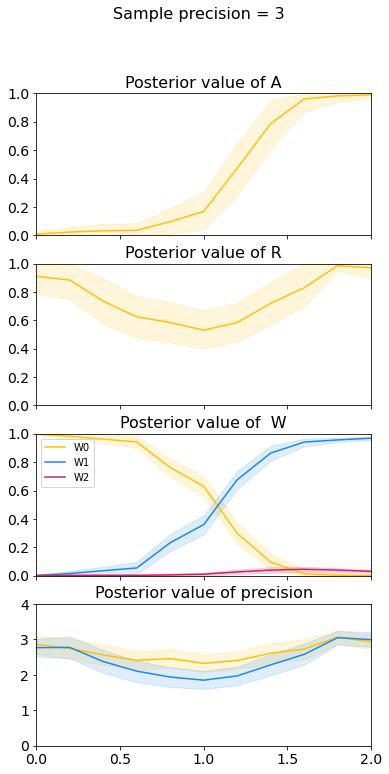

In [ ]:
range_plot(high_precision)

In [ ]:
low_precision = inference_range(1)

Maximum Rhat for A = 1.2 at coordinate 2.0
Maximum Rhat for weights[0] = 1.41 at coordinate 2.0
Maximum Rhat for weights[1] = 1.05 at coordinate 0.0
Maximum Rhat for weights[2] = 1.04 at coordinate 0.0
Maximum Rhat for R = 1.0 at coordinate 0.0
Maximum Rhat for precision[0] = 1.0 at coordinate 0.0
Maximum Rhat for precision[1] = 1.01 at coordinate 0.2


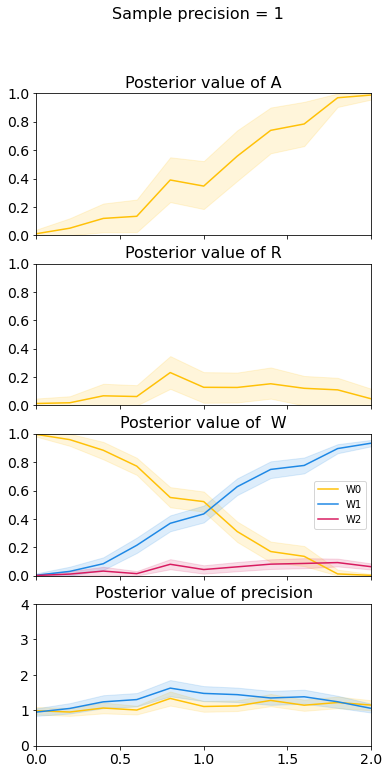

In [ ]:
range_plot(low_precision)

An asymmetry is revealed between perception and imagery. The model shows source confusions for perceived stimuli when stimuli are at threshold. The next section investigates how source confusions might occur for imagined stimuli - when imagined stimuli are mistakenly throught to be real. 

Some more plotting functions first. 

In [ ]:
def plot_bars(data_list, titles):

  n_plots = len(data_list)
  data_dict = {}

  # set variable and parameters to extract from data list
  vars = ['A', 'R', 'weights[0]', 'weights[1]', 'weights[2]']
  data_params = ['mean', 'hdi_2.5%', 'hdi_97.5%', 'r_hat']

  # initialise data lists
  for var in vars: 
      data_dict[var] = {}
      for param in data_params:
        data_dict[var][param] = []
  
  # extract data
  for data in data_list:
    summary_table = az.summary(data, hdi_prob=0.95)

    for var in vars: 
      for param in data_params:
        data_dict[var][param].append((summary_table[param][var]))

  fig, ax = plt.subplots(ncols = n_plots, figsize=(5*n_plots, 4), sharey=True)

  ticklabels = ['A', 'R', 'W0', 'W1', 'W2']
  colors = ['#1E88E5', '#FFC107', '#D81B60', '#1E88E5', '#FFC107']
  locs = [1, 2, 4, 5, 6]

  for i in range(n_plots):

    meanslist = [data_dict[var]['mean'][i] for var in vars]
    upper_CI = [data_dict[var]['hdi_97.5%'][i] for var in vars]
    lower_CI = [data_dict[var]['hdi_2.5%'][i] for var in vars]

    upper_err = np.array(upper_CI) - np.array(meanslist)
    lower_err = np.array(meanslist) - np.array(lower_CI)

    err_bars = np.ones((2, 5))
    err_bars[0, :] = upper_err
    err_bars[1, :] = lower_err

    ax[i].bar(locs, meanslist, 1, yerr = err_bars, 
              tick_label=ticklabels, color=colors)

    ax[i].set_title(titles[i], fontsize=16)

  ax[0].set_ylabel('Posterior mean', fontsize=16)
  ax[0].set_ylim(0, 1)

  plt.show()

Two hypotheses are explored about source confusions for imagined stimuli. 

**Figure 6.** Model output of imagery corresponding to fewer samples being used as input data to the generative model.

In [ ]:
n_samples_effect = []

for nsamples in [20, 50, 100]:

  X_samples = gen_X_samples([0, 2], 1, nsamples)

  n_samples_effect.append(hoss_prm(X_samples=X_samples, A_alpha=1, A_beta=9, ndraws=12000))

In [ ]:
az.summary(n_samples_effect[1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
copula_dist[0],-0.820,0.467,-1.751,-0.109,0.020,0.014,386.0,727.0,1.01
copula_dist[1],3.519,0.658,2.300,4.773,0.016,0.012,1598.0,3027.0,1.00
precision[0],1.296,0.214,0.938,1.703,0.011,0.008,418.0,912.0,1.01
precision[1],1.295,0.220,0.926,1.712,0.011,0.008,417.0,865.0,1.01
weights[0],0.252,0.080,0.103,0.401,0.002,0.002,1332.0,2469.0,1.00
weights[1],0.610,0.067,0.488,0.738,0.002,0.001,1822.0,3771.0,1.00
weights[2],0.138,0.040,0.067,0.216,0.001,0.000,3230.0,6541.0,1.00
R,0.145,0.107,0.000,0.327,0.006,0.004,386.0,727.0,1.01
A,0.603,0.105,0.406,0.795,0.003,0.002,1598.0,3027.0,1.00


In [ ]:
az.summary(n_samples_effect[2])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
copula_dist[0],-1.137,0.487,-2.126,-0.468,0.012,0.008,1315.0,1383.0,1.0
copula_dist[1],4.046,0.618,2.860,5.187,0.014,0.010,2021.0,4240.0,1.0
precision[0],1.124,0.130,0.901,1.377,0.003,0.002,1591.0,1826.0,1.0
precision[1],1.163,0.134,0.900,1.406,0.003,0.003,1603.0,2181.0,1.0
weights[0],0.154,0.053,0.059,0.254,0.001,0.001,1694.0,2749.0,1.0
weights[1],0.737,0.047,0.648,0.822,0.001,0.001,2319.0,4240.0,1.0
weights[2],0.110,0.028,0.056,0.161,0.000,0.000,4823.0,8023.0,1.0
R,0.071,0.062,0.000,0.185,0.002,0.001,1315.0,1383.0,1.0
A,0.684,0.090,0.511,0.843,0.002,0.001,2021.0,4240.0,1.0


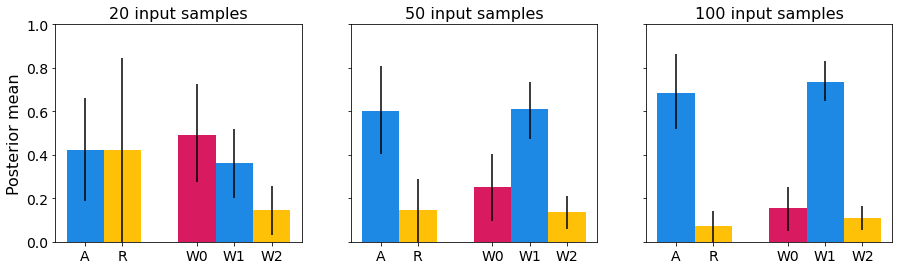

In [ ]:
plot_bars(n_samples_effect, ['20 input samples', '50 input samples', '100 input samples'])

**Figure 6.** Model output of varying the correlation parameter *rho* in the prior distribution. 

In [ ]:
copula_effect = []

for rho in [0, 0.9, 0.99]:

  X_samples = gen_X_samples([0, 2], 1, 500)

  copula_effect.append(hoss_prm(X_samples=X_samples, rho=rho, ndraws=12000))

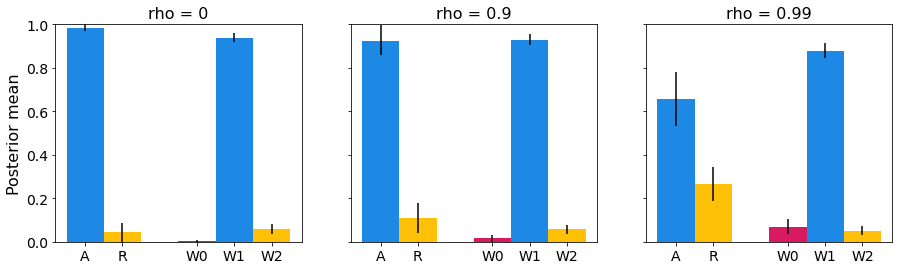

In [ ]:
plot_bars(copula_effect, ['rho = 0', 'rho = 0.9', 'rho = 0.99'])

**Figure 7.** Generating predictions from the model about the outcomes of an experiment comparing imagined presences to perceived absences.

In [ ]:
copula_only = []

for mean, precision in zip([[0, 2], [0, 0]], [1, 3]):

  X_samples = gen_X_samples(mean, precision, 500)
  copula_only.append(hoss_prm(X_samples, rho=0.99, ndraws=12000))

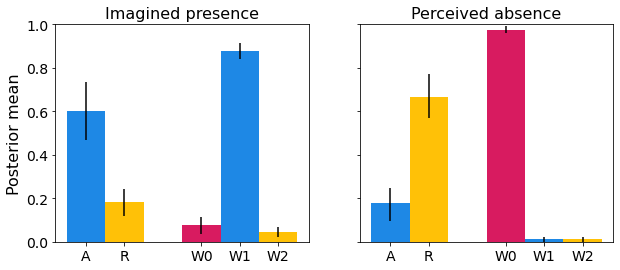

In [ ]:
plot_bars(copula_only, ['Imagined presence', 'Perceived absence'])

In [ ]:
sample_size_only = []

for mean, precision, nsamples in zip([[0, 2], [0, 0]], [1, 3], [30, 500]):
  X_samples = gen_X_samples(mean, precision, nsamples)
  sample_size_only.append(hoss_prm(X_samples, ndraws=12000))

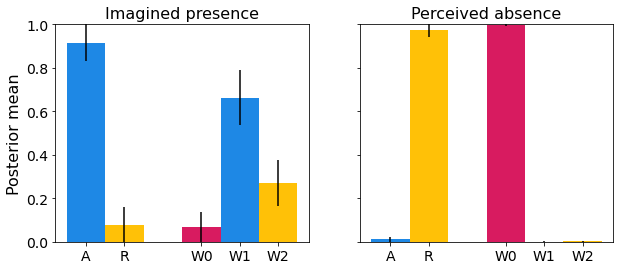

In [ ]:
plot_bars(sample_size_only, ['Imagined presence', 'Perceived absence'])

In [ ]:
both_hypotheses = []

for mean, precision, nsamples in zip([[0, 2], [0, 0]], 
                                     [1, 3], [50, 500]):
  X_samples = gen_X_samples(mean, precision, nsamples)
  both_hypotheses.append(hoss_prm(X_samples, rho=0.99, ndraws=12000))

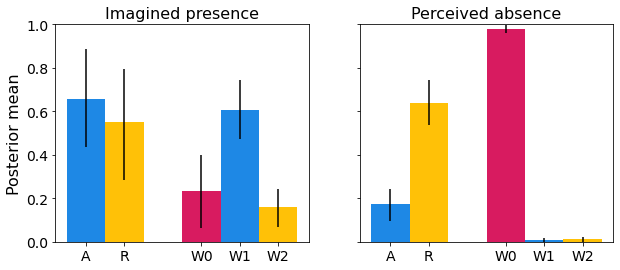

In [ ]:
plot_bars(both_hypotheses, ['Imagined presence', 'Perceived absence'])